## The Forward model

In [18]:
import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [19]:
from brian2 import *
from matplotlib import pyplot as plt
import Documentation.parameters as p
from Foundations.helpers import scale_input_theory, make_spiketrain
from Foundations.MI import analyze_exp
import pandas as pd

In [20]:
from Old_testing.make_dynamic_experiment_ori import make_dynamic_experiments
from Old_testing.currentmodel import Barrel_PC, Barrel_IN

In [21]:
defaultclock = p.dt*ms
np.random.seed()
seed = np.random.randint(1000000000)

In [22]:
[input_theory, hidden_state] = make_dynamic_experiments(p.qon_qoff_type, p.baseline, p.tau, p.factor_ron_roff, p.mean_firing_rate, p.sampling_rate, p.duration)

inj_current = scale_input_theory(input_theory, 0, 17, p.dt)

[]

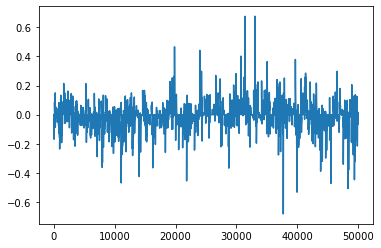

[]

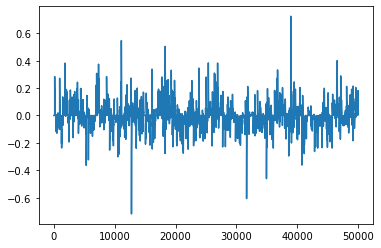

In [23]:
plt.plot(input_theory)
plt.plot()

In [24]:
start_scope()
IN = Barrel_IN(p.dt, inj_current)

IN_neuron = IN.getNeurongroup()

IN_M = StateMonitor(IN_neuron, 'v', record=True)
IN_S = SpikeMonitor(IN_neuron, 'v', record = True)

run(p.duration*ms)

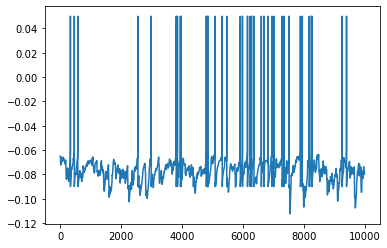

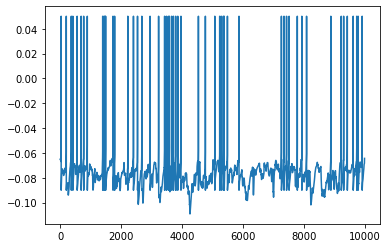

In [25]:
plot(IN_M.t / ms, IN_M.v[0], label='IN_pre')

In [26]:
start_scope()
#Initialising the neuron classes using both inj_current_IN
PC = Barrel_PC(p.dt, inj_current)
IN = Barrel_IN(p.dt, inj_current)
#Getting the neurongroups, PC_neuron returns a neurongroup with two neurons.
PC_neuron = PC.getNeurongroup()
IN_neuron = IN.getNeurongroup()
#Making a brain2 network with the neurons
net = Network(PC_neuron, IN_neuron)

PC_M = StateMonitor(PC_neuron, 'v', record=True)
PC_S = SpikeMonitor(PC_neuron, 'v', record =True)
IN_M = StateMonitor(IN_neuron, 'v', record=True)
IN_S = SpikeMonitor(IN_neuron, 'v', record =True)

net.add(PC_M, IN_M, PC_S, IN_S)
#Setting the weight and the delay for the synapses, and connect the interneuron to the second excitatory neuron
w = 4.3
delay = 0.6

syn = Synapses(IN_neuron, PC_neuron, on_pre='''v_post += w*mV''', delay= delay*ms, dt=p.dt * ms)
syn.connect(i=0, j=1)
net.add(syn)

net.run(p.duration*ms)

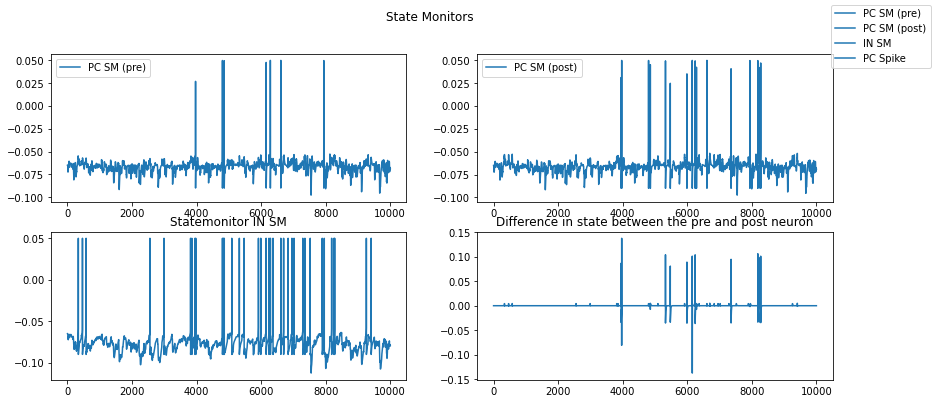

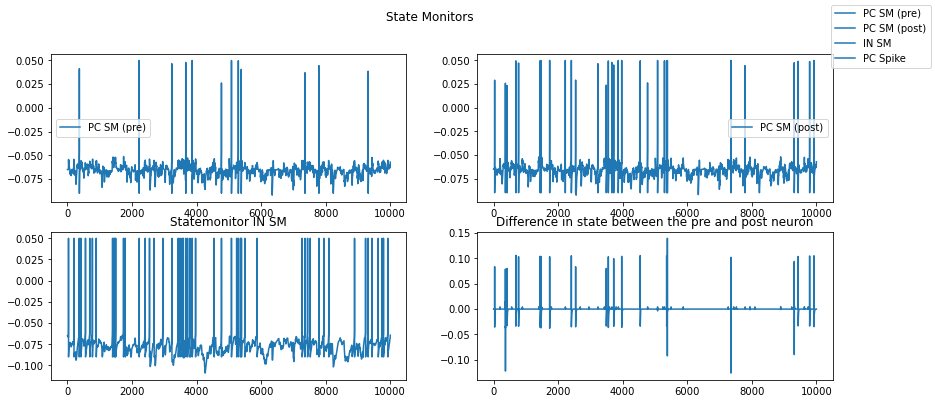

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(14,6))

axs[0, 0].plot(PC_M.t/ms, PC_M.v[0], label= 'PC SM (pre)')
axs[0,0].legend()
axs[0, 1].plot(PC_M.t/ms, PC_M.v[1], label= 'PC SM (post)')
axs[0,1].legend()

axs[1, 0].plot(IN_M.t/ms, IN_M.v[0], label= 'IN SM')
axs[1, 0].set_title('Statemonitor IN SM')

axs[1, 1].plot(PC_M.t/ms, PC_M.v[1] - PC_M.v[0], label= 'PC Spike')
axs[1, 1].set_title('Difference in state between the pre and post neuron')

fig.suptitle('State Monitors')
fig.legend()
plt.show()

## Analyzing the network

In [28]:
#the spiketrain of the modulated neuron
spiketrain_PC = make_spiketrain(PC_S.values('v')[1])
spiketrain_IN = make_spiketrain(IN_S)

In [29]:
output_PC = analyze_exp(hidden_state, input_theory, 0, spiketrain_PC, p.duration/p.sampling_rate, 'PC neuron')
output_IN = analyze_exp(hidden_state, input_theory, 0, spiketrain_IN, p.duration/p.sampling_rate, 'Input neuron')

WARNING    C:\Users\laure\DataspellProjects\BacherlorStage\Foundations\helpers.py:138: RuntimeWarning: divide by zero encountered in log
  w = np.log(qon/qoff)
 [py.warnings]
WARNING    C:\Users\laure\DataspellProjects\BacherlorStage\Foundations\helpers.py:100: RuntimeWarning: invalid value encountered in double_scalars
  dLdt = p.ron * (1. + np.exp(-L)) - p.roff * (1. + np.exp(L)) + w*I - theta
 [py.warnings]


no down spikes, inventing one


WARNING    C:\Users\laure\DataspellProjects\BacherlorStage\Foundations\helpers.py:117: RuntimeWarning: divide by zero encountered in log2
  Hxy = - np.mean(x * np.log2(p_conditional(L)) + (1 - x) * np.log2(1 - p_conditional(L)))
 [py.warnings]
WARNING    C:\Users\laure\DataspellProjects\BacherlorStage\Foundations\helpers.py:138: RuntimeWarning: divide by zero encountered in log
  w = np.log(qon/qoff)
 [py.warnings]
WARNING    C:\Users\laure\DataspellProjects\BacherlorStage\Foundations\helpers.py:100: RuntimeWarning: invalid value encountered in double_scalars
  dLdt = p.ron * (1. + np.exp(-L)) - p.roff * (1. + np.exp(L)) + w*I - theta
 [py.warnings]


no down spikes, inventing one


WARNING    C:\Users\laure\DataspellProjects\BacherlorStage\Foundations\helpers.py:117: RuntimeWarning: divide by zero encountered in log2
  Hxy = - np.mean(x * np.log2(p_conditional(L)) + (1 - x) * np.log2(1 - p_conditional(L)))
 [py.warnings]
WARNING    C:\Users\laure\DataspellProjects\BacherlorStage\Foundations\helpers.py:117: RuntimeWarning: invalid value encountered in multiply
  Hxy = - np.mean(x * np.log2(p_conditional(L)) + (1 - x) * np.log2(1 - p_conditional(L)))
 [py.warnings]


In [30]:
output_IN

,weigts,Hxx,Hxy,MI_i,xhat_i,MSE_i,MI,qon,qoff,xhatspikes,MSE,F,F_I
0,Input neuron,0.955983,0.776298,0.179685,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.450335,-2.941854,0.00716,0.001284,"[0.3333333333333333, 0.2617709351564629, 0.200...",9.41354,0.187958,-16.372298


,weigts,Hxx,Hxy,MI_i,xhat_i,MSE_i,MI,qon,qoff,xhatspikes,MSE,F,F_I
0,Input neuron,0.966129,0.728597,0.237532,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.06049,-2.988443,0.008417,0.001974,"[0.3333333333333333, 0.27226069502006195, 0.21...",9.782623,0.24586,-12.581219


In [31]:
output_PC

,weigts,Hxx,Hxy,MI_i,xhat_i,MSE_i,MI,qon,qoff,xhatspikes,MSE,F,F_I
0,PC neuron,0.955983,0.776298,0.179685,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.450335,NaN,0.0,0.000161,"[0.3333333333333333, 1.0, nan, nan, nan, nan, ...",NaN,0.187958,NaN


,weigts,Hxx,Hxy,MI_i,xhat_i,MSE_i,MI,qon,qoff,xhatspikes,MSE,F,F_I
0,PC neuron,0.966129,0.728597,0.237532,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.06049,NaN,0.0,0.000164,"[0.3333333333333333, 1.0, nan, nan, nan, nan, ...",NaN,0.24586,NaN


# Analyzing the network

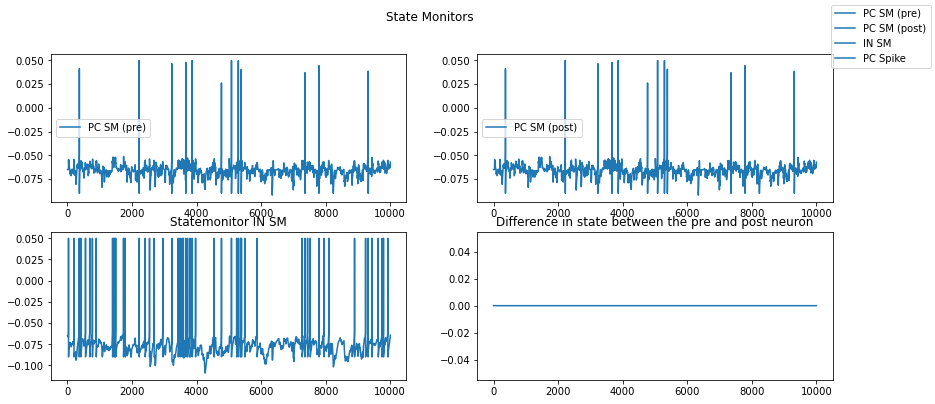

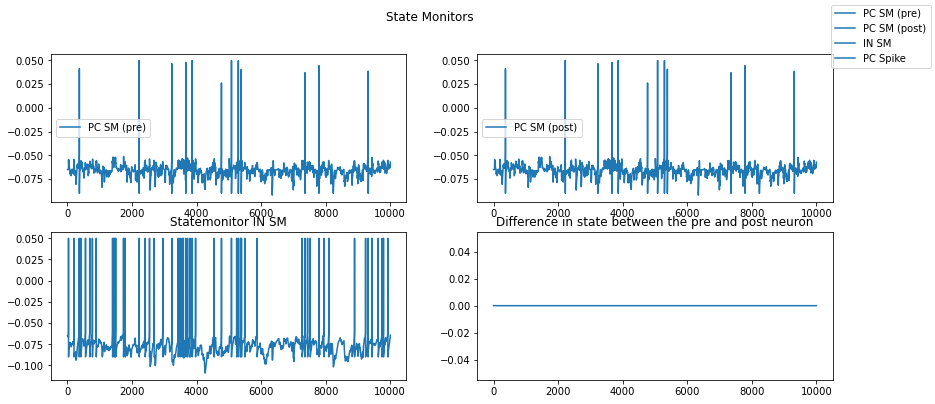

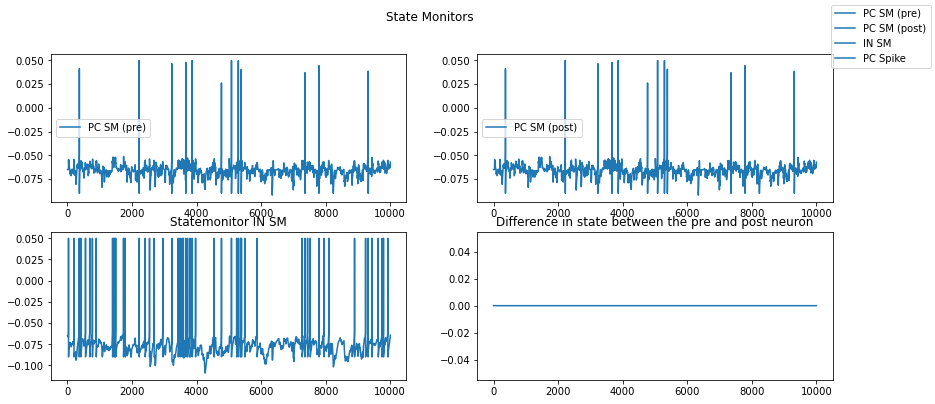

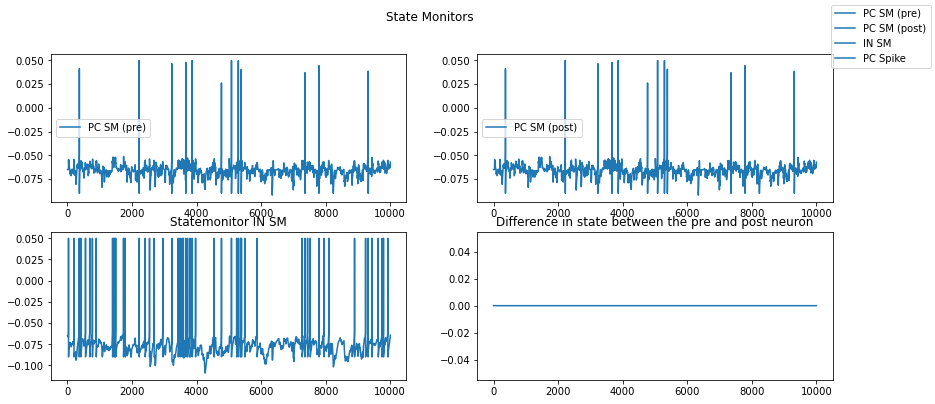

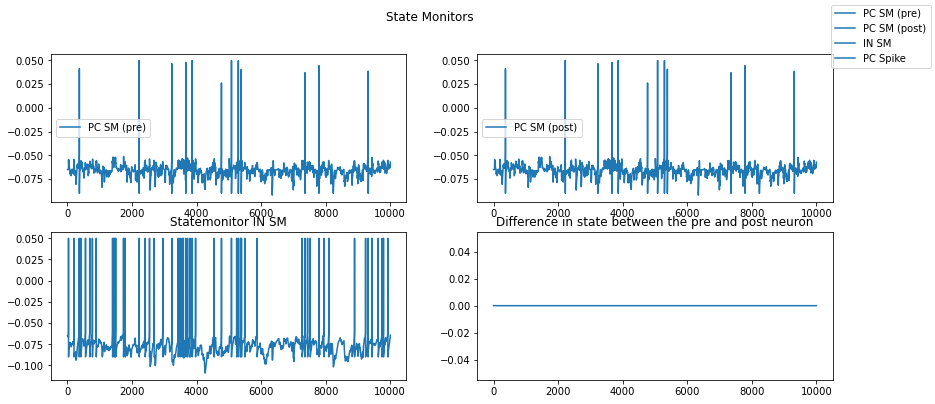

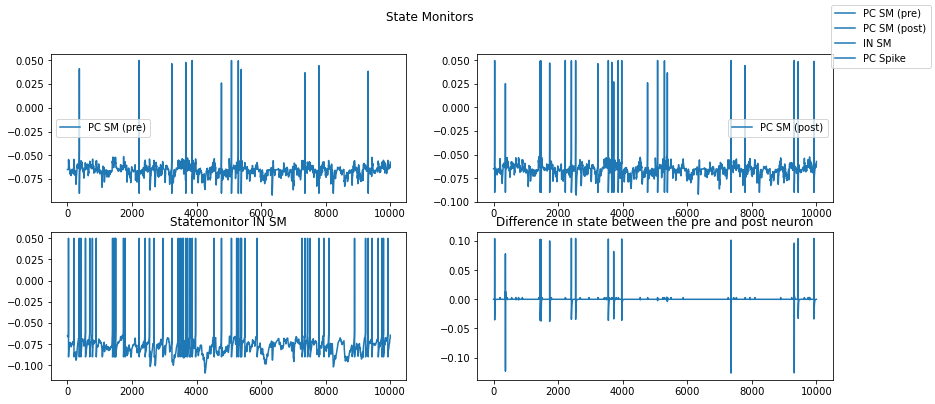

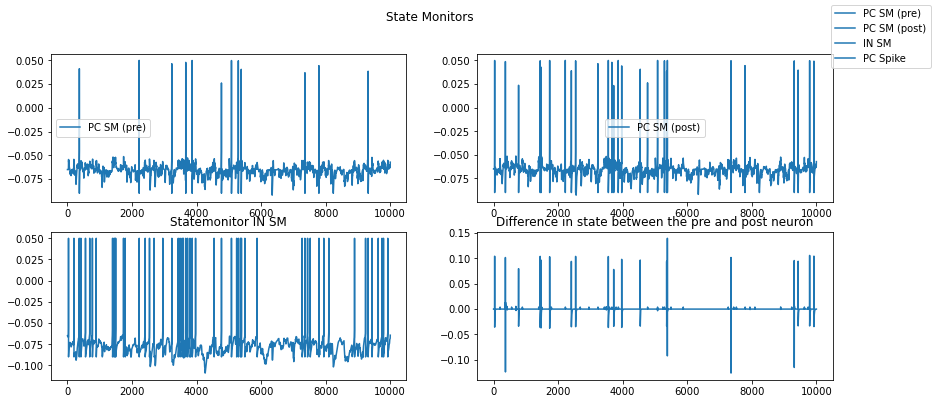

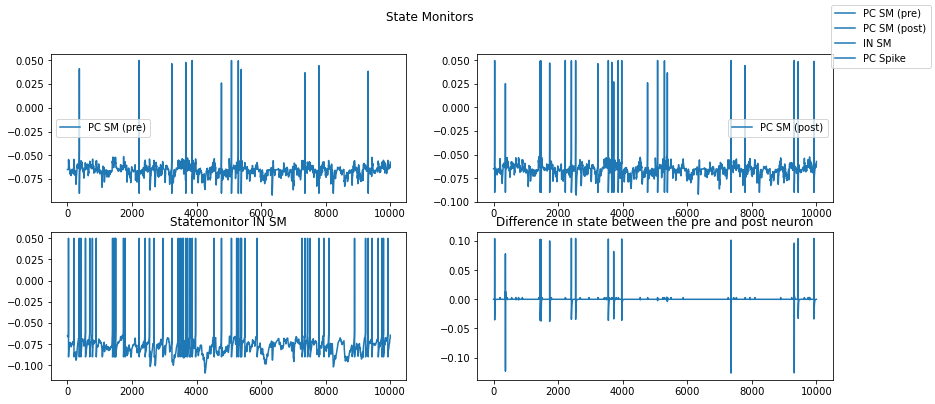

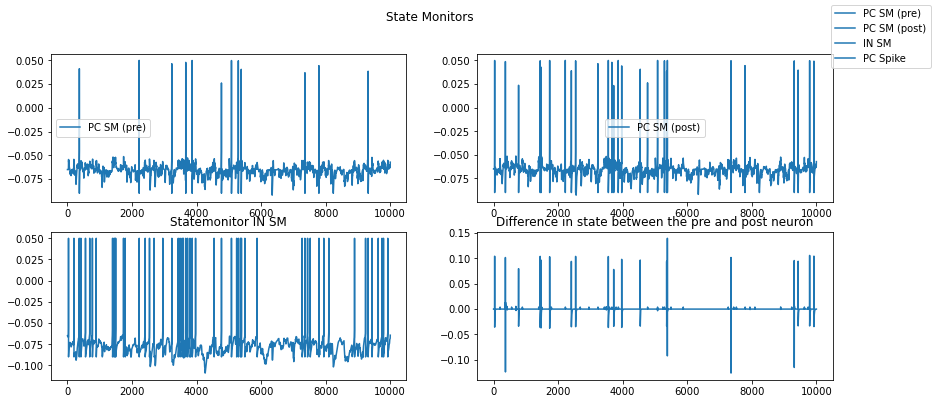

In [44]:
start_scope()
#Initialising the neuron classes
PC = Barrel_PC(p.dt, inj_current)
IN = Barrel_IN(p.dt, inj_current) #the barrel neuron has no input
#Getting the neuron groups
PC_neuron = PC.getNeurongroup()
IN_neuron = IN.getNeurongroup()

net2 = Network(PC_neuron,
               IN_neuron)

PC_M = StateMonitor(PC_neuron, 'v', record=True)
PC_S = SpikeMonitor(PC_neuron, 'v', record = True)
IN_M = StateMonitor(IN_neuron, 'v', record=True)
IN_S = SpikeMonitor(PC_neuron, 'v', record = True)

net2.add(PC_M, IN_M, PC_S, IN_S)
w = np.arange(1,15)
#getting all the parameters for in the synapse
delay = 0.6

syn2 = Synapses(IN_neuron, PC_neuron, on_pre='''v_post += w*mV''', delay= delay*ms, dt=p.dt * ms)
syn2.connect(i=0, j=1)
net2.add(syn2)

net2.store()

output_PC = pd.DataFrame()
output_IN = pd.DataFrame()
weights = [3,4]
samples = p.duration/p.dt

for w in weights:
    net2.restore()
    w = w
    label = str(w)
    net2.run(p.duration*ms)
    spiketrain = make_spiketrain(PC_S)

    fig, axs = plt.subplots(2, 2, figsize=(14,6))

    axs[0, 0].plot(PC_M.t/ms, PC_M.v[0], label= 'PC SM (pre)')
    axs[0,0].legend()
    axs[0, 1].plot(PC_M.t/ms, PC_M.v[1], label= 'PC SM (post)')
    axs[0,1].legend()

    axs[1, 0].plot(IN_M.t/ms, IN_M.v[0], label= 'IN SM')
    axs[1, 0].set_title('Statemonitor IN SM')

    axs[1, 1].plot(PC_M.t/ms, PC_M.v[1] - PC_M.v[0], label= 'PC Spike')
    axs[1, 1].set_title('Difference in state between the pre and post neuron')



    fig.suptitle('State Monitors')
    fig.legend()
    plt.show()

    output_PC = pd.concat([output_PC, analyze_exp(hidden_state, input_theory,0, spiketrain,samples, 'none')], axis = 0)
    output_IN = pd.concat([output_IN, analyze_exp(hidden_state, input_theory, 0, spiketrain, p.duration/p.sampling_rate, w)], axis =0)

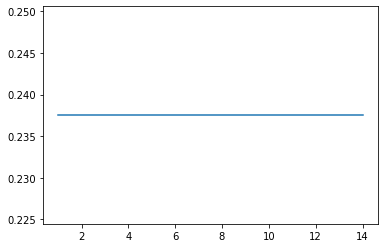

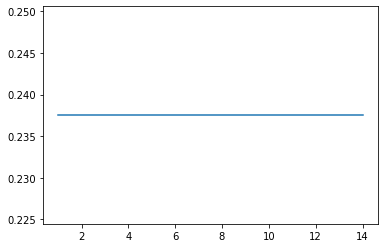

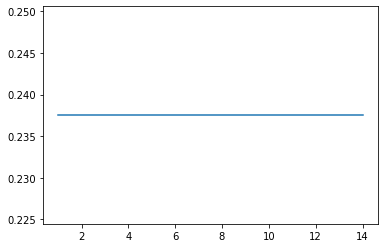

In [38]:
plt.figure()
plt.plot(weights, output_PC['MI_i'])
plt.show()

In [34]:
output_IN

,weigts,Hxx,Hxy,MI_i,xhat_i,MSE_i,MI,qon,qoff,xhatspikes,MSE,F,F_I
0,1,0.955983,0.776298,0.179685,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.450335,-3.098616,0.001591,0.000161,"[0.3333333333333333, 0.24015002808853686, 0.16...",9.417169,0.187958,-17.244726
0,2,0.955983,0.776298,0.179685,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.450335,-3.098616,0.001591,0.000161,"[0.3333333333333333, 0.24015002808853686, 0.16...",9.417169,0.187958,-17.244726
0,3,0.955983,0.776298,0.179685,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.450335,-3.098616,0.001591,0.000161,"[0.3333333333333333, 0.24015002808853686, 0.16...",9.417169,0.187958,-17.244726
0,4,0.955983,0.776298,0.179685,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.450335,-3.098616,0.001591,0.000161,"[0.3333333333333333, 0.24015002808853686, 0.16...",9.417169,0.187958,-17.244726
0,5,0.955983,0.776298,0.179685,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.450335,-3.098616,0.001591,0.000161,"[0.3333333333333333, 0.24015002808853686, 0.16...",9.417169,0.187958,-17.244726
0,6,0.955983,0.776298,0.179685,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.450335,-3.098616,0.001591,0.000161,"[0.3333333333333333, 0.24015002808853686, 0.16...",9.417169,0.187958,-17.244726
0,7,0.955983,0.776298,0.179685,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.450335,-3.098616,0.001591,0.000161,"[0.3333333333333333, 0.24015002808853686, 0.16...",9.417169,0.187958,-17.244726
0,8,0.955983,0.776298,0.179685,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.450335,-3.098616,0.001591,0.000161,"[0.3333333333333333, 0.24015002808853686, 0.16...",9.417169,0.187958,-17.244726
0,9,0.955983,0.776298,0.179685,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.450335,-3.098616,0.001591,0.000161,"[0.3333333333333333, 0.24015002808853686, 0.16...",9.417169,0.187958,-17.244726
0,10,0.955983,0.776298,0.179685,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.450335,-3.098616,0.001591,0.000161,"[0.3333333333333333, 0.24015002808853686, 0.16...",9.417169,0.187958,-17.244726


,weigts,Hxx,Hxy,MI_i,xhat_i,MSE_i,MI,qon,qoff,xhatspikes,MSE,F,F_I
0,1,0.966129,0.728597,0.237532,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.06049,-3.348497,0.00255,0.000164,"[0.3333333333333333, 0.22419592412803913, 0.14...",9.791664,0.24586,-14.097033
0,2,0.966129,0.728597,0.237532,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.06049,-3.348497,0.00255,0.000164,"[0.3333333333333333, 0.22419592412803913, 0.14...",9.791664,0.24586,-14.097033
0,3,0.966129,0.728597,0.237532,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.06049,-3.348497,0.00255,0.000164,"[0.3333333333333333, 0.22419592412803913, 0.14...",9.791664,0.24586,-14.097033
0,4,0.966129,0.728597,0.237532,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.06049,-3.348497,0.00255,0.000164,"[0.3333333333333333, 0.22419592412803913, 0.14...",9.791664,0.24586,-14.097033
0,5,0.966129,0.728597,0.237532,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.06049,-3.348497,0.00255,0.000164,"[0.3333333333333333, 0.22419592412803913, 0.14...",9.791664,0.24586,-14.097033
0,6,0.966129,0.728597,0.237532,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.06049,-3.348497,0.00255,0.000164,"[0.3333333333333333, 0.22419592412803913, 0.14...",9.791664,0.24586,-14.097033
0,7,0.966129,0.728597,0.237532,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.06049,-3.348497,0.00255,0.000164,"[0.3333333333333333, 0.22419592412803913, 0.14...",9.791664,0.24586,-14.097033
0,8,0.966129,0.728597,0.237532,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.06049,-3.348497,0.00255,0.000164,"[0.3333333333333333, 0.22419592412803913, 0.14...",9.791664,0.24586,-14.097033
0,9,0.966129,0.728597,0.237532,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.06049,-3.348497,0.00255,0.000164,"[0.3333333333333333, 0.22419592412803913, 0.14...",9.791664,0.24586,-14.097033
0,10,0.966129,0.728597,0.237532,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.06049,-3.348497,0.00255,0.000164,"[0.3333333333333333, 0.22419592412803913, 0.14...",9.791664,0.24586,-14.097033
